In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
from torch.utils.data import Subset, TensorDataset, DataLoader
from matplotlib import pyplot as plt
import copy
import torch.nn.init as init

In [ ]:
# Arguments
args = {
    'lr': 1e-3, #lr for MLP model
    'bs': 128, #batch size for both models
    'epochs': 5, #epochs for MLP model
    'num_tasks': 5, #number of tasks
    'dataset': "MNIST", #dataset
    'num_classes': 10,
    'in_size': 28,
    'n_channels': 1,
    'hidden_size': 400, #hidden size of the VAE
    'latent_dim': 100,  # Latent dimension of VAE
    'task_names': ['task_0', 'task_1', 'task_2', 'task_3', 'task_4'],
    'vae_epochs': 50,
    'vae_lr':1e-2,  # Standard learning rate for VAE
    'vae_lr_decay': 1e-5,  # Learning rate decay factor
    'vae_lr_step_size': 100, # Step size for learning rate decay# Specify task names here# Example number of replay samples
}

##Dataset

In [ ]:
#function to get dataset
def get_dataset(dataroot, dataset):
    if dataset == 'MNIST':
        mean, std = (0.1307,), (0.3081,)
    elif dataset == 'CIFAR10':
        mean, std = (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)

    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=mean, std=std),
        torchvision.transforms.Lambda(lambda x: x.clamp(0, 1))  # Ensure values are within [0, 1]
    ])

    train_dataset = torchvision.datasets.__dict__[dataset](
        root=dataroot,
        train=True,
        download=True,
        transform=transform
    )

    val_dataset = torchvision.datasets.__dict__[dataset](
        root=dataroot,
        train=False,
        download=True,
        transform=transform
    )

    return train_dataset, val_dataset

#function to split the dataset
def split_dataset(dataset, tasks_split):
    split_dataset = {}
    for e, current_classes in tasks_split.items():
        task_indices = np.isin(np.array(dataset.targets), current_classes)
        subset_indices = np.where(task_indices)[0]
        split_dataset[e] = Subset(dataset, subset_indices)
        print(f"Task {e}: {len(subset_indices)} examples")
    return split_dataset

##Metrics and plotting

In [ ]:
def dict2array(acc):
    num_tasks = len(acc)
    first_task = list(acc.keys())[0]
    sequence_length = len(acc[first_task]) if isinstance(acc[first_task], list) else num_tasks
    acc_array = np.zeros((num_tasks, sequence_length))
    for task, val in acc.items():
        acc_array[int(task), :] = val
    return acc_array


def plot_accuracy_matrix(array):
    num_tasks = array.shape[1]
    array = np.round(array, 2)
    fig, ax = plt.subplots()
    ax.imshow(array, vmin=np.min(array), vmax=np.max(array))
    for i in range(len(array)):
        for j in range(array.shape[1]):
            ax.text(j,i, array[i,j], va='center', ha='center', c='w', fontsize=15)
    ax.set_yticks(np.arange(num_tasks))
    ax.set_ylabel('Number of tasks')
    ax.set_xticks(np.arange(num_tasks))
    ax.set_xlabel('Tasks finished')
    ax.set_title(f"ACC: {np.mean(array[:, -1]):.3f} -- std {np.std(np.mean(array[:, -1])):.3f}")
    plt.show()


def plot_acc_over_time(array):
    fig, ax = plt.subplots()
    for e, acc in enumerate(array):
        ax.plot(acc, label=e)
    plt.legend()
    plt.show()


def compute_average_accuracy(array):
    num_tasks = len(array)
    avg_acc = np.sum(array[:, -1], axis=0)/num_tasks
    return avg_acc


def compute_backward_transfer(array):
    num_tasks = len(array)
    diag = np.diag(array)[:-1] # Note, we do not compute backward transfer for the last task!
    end_acc = array[:-1, -1]
    bwt = np.sum(end_acc - diag)/(num_tasks - 1)
    return bwt


def compute_forward_transfer(array, b):
    num_tasks = len(array)
    sub_diag = np.diag(array, k=-1) # Note, we do not compute forward transfer for the first task!
    fwt = np.sum(sub_diag - b[1:])/(num_tasks - 1)
    return fwt

In [ ]:
class MetricLogger:
    def __init__(self):
        # Initialize lists to store logged values
        self.model_sizes = []
        self.vae_model_sizes = []
        self.initial_model_size = None

    # Log the size of the model (number of parameters)
    def log_model_size(self, model):
        model_size = sum(p.numel() for p in model.parameters())  # Calculate total number of parameters in the model
        self.model_sizes.append(model_size)
        if self.initial_model_size is None:
            self.initial_model_size = model_size  # Set initial model size if not already set

    # Log the size of the VAE model (number of parameters)
    def log_vae_model_size(self, vae):
        vae_model_size = sum(p.numel() for p in vae.parameters())  # Calculate total number of parameters in the VAE model
        self.vae_model_sizes.append(vae_model_size)

    # Calculate the Model Size Efficiency (MS)
    def model_size_efficiency(self):
        # Compute the efficiency values for each task
        ms_values = [self.initial_model_size / size for size in self.model_sizes]
        # Calculate the final MS metric
        ms = min(1, sum(ms_values) / len(ms_values))
        return ms

##Models

In [ ]:
import torch.nn.functional as F
import torch.nn.init as init

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=400, latent_dim=100, dropout_prob=0.1, weight_decay=1e-5):
        super(VAE, self).__init__()
        self.dropout_prob = dropout_prob
        self.weight_decay = weight_decay

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob)
        )
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

        self.initialize_parameters()

    def initialize_parameters(self):
        # Xavier/Glorot initialization for encoder and decoder layers
        for layer in self.encoder:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.constant_(layer.bias, 0)
        for layer in self.decoder:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
                nn.init.constant_(layer.bias, 0)

    def encode(self, x):
        # Encoder forward pass
        h1 = self.encoder(x)
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        # Reparameterization trick to sample from the latent space
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        # Decoder forward pass
        return self.decoder(z)

    def forward(self, x):
        # Forward pass through encoder and decoder
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        # Compute reconstruction loss (BCE) and KL divergence (KLD)
        BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD

    def configure_optimizers(self):
        # Adam optimizer with weight decay
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=self.weight_decay)
        return optimizer

    def generate_samples(self, num_samples):
        # Generate samples from the VAE model
        with torch.no_grad():
            z = torch.randn(num_samples, self.fc21.out_features).to(next(self.parameters()).device)
            samples = self.decode(z).cpu()
        return samples

In [ ]:
# MLP Model
class MLP(nn.Module):
    def __init__(self, args):
        super(MLP, self).__init__()
        self.args = args
        input_size = args['in_size'] ** 2 * args['n_channels']
        hidden_size = args['hidden_size']
        output_size = args['num_classes']
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.layers(x.view(x.size(0), -1))

##Agent

In [ ]:
class Agent:
    def __init__(self, args, train_datasets, val_datasets, saved_model=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.args = args
        self.model = MLP(self.args).to(self.device)
        self.vae = VAE(self.args['in_size'] ** 2 * self.args['n_channels']).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.args['lr'])
        self.vae_optimizer = torch.optim.Adam(self.vae.parameters(), lr=self.args['vae_lr'])
        self.criterion = torch.nn.CrossEntropyLoss()
        self.train_datasets = train_datasets  # Initialize train_datasets attribute
        self.val_datasets = val_datasets
        self.reset_acc()
        self.vae_epochs = self.args['vae_epochs']
        self.vae_lr = self.args['vae_lr']  # Define initial learning rate for VAE training
        self.vae_lr_decay = self.args['vae_lr_decay']  # Define learning rate decay factor for VAE
        self.vae_lr_step_size = self.args['vae_lr_step_size']  # Define step size for learning rate decay for VAE
        self.metric_logger = MetricLogger()

    def reset_acc(self):
        self.acc = {key: [] for key in self.train_datasets.keys()}
        self.acc_end = {key: [] for key in self.train_datasets.keys()}

    def train(self):
        for task, data in self.train_datasets.items():
            print(f"Task {task}")
            int_task = int(task)
            N_tasks_so_far = int_task + 1  # Number of tasks encountered so far

            if task == '0':
                loader = DataLoader(data, batch_size=self.args['bs'], shuffle=True)
            else:
                dataset_size = len(data)
                replay_data, replay_labels = self.replay_data(dataset_size)
                all_data = [data[idx][0].view(1, 28, 28) for idx in range(len(data))]
                all_targets = [data[idx][1] for idx in range(len(data))]
                all_data_tensor = torch.cat(all_data, dim=0).to(self.device)
                all_targets_tensor = torch.tensor(all_targets).to(self.device)

                if replay_data is not None:
                    all_data = torch.cat((all_data_tensor, replay_data.view(-1, 28, 28)))
                    all_labels = torch.cat((all_targets_tensor, replay_labels))
                else:
                    all_data = data.dataset.data
                    all_labels = data.dataset.targets

                loader = DataLoader(TensorDataset(all_data, all_labels), batch_size=self.args['bs'], shuffle=True)

            for epoch in range(self.args['epochs']):
                epoch_loss = 0
                total = 0
                correct = 0
                computations = 0  # Initialize computation count for this epoch
                for e, (X, y) in enumerate(loader):
                    X, y = X.to(self.device), y.to(self.device)

                    output = self.model(X)
                    L_current = self.criterion(output, y)

                    if int_task > 0:
                        replay_data, replay_labels = self.replay_data(len(X))
                        if replay_data is not None and replay_labels is not None:
                            replay_output = self.model(replay_data)
                            L_replay = self.criterion(replay_output, replay_labels)
                        else:
                            L_replay = 0

                        #Weighted sum of the current task loss and replay loss
                        loss = (1 / N_tasks_so_far) * L_current + (1 - 1 / N_tasks_so_far) * L_replay
                    else:
                        loss = L_current

                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    epoch_loss += loss.item()
                    correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y)
                    total += len(X)
                    if e % 50 == 0:
                        self.validate()
                print(f"MLP Training Epoch {epoch}: Loss {epoch_loss / (e + 1):.3f} Acc: {correct / total:.3f}")

                # Log computations after each epoch
                self.metric_logger.log_computations(computations)

            self.validate(end_of_epoch=True)

            if task != '4':
               self.train_vae(task, loader)  #Pass the loader directly to train_vae

    def train_vae(self, task, loader):
        self.vae_optimizer = torch.optim.Adam(self.vae.parameters(), lr=self.vae_lr)
        vae_scheduler = torch.optim.lr_scheduler.StepLR(self.vae_optimizer, step_size=self.vae_lr_step_size, gamma=self.vae_lr_decay)
        task = int(task)
        N_tasks_so_far = task + 1

        for epoch in range(self.vae_epochs):
            self.vae.train()
            train_loss = 0
            recon_loss = 0
            for batch_idx, (data, _) in enumerate(loader):
                data = data.to(self.device)
                self.vae_optimizer.zero_grad()

                recon_batch, mu, logvar = self.vae(data.view(-1, self.args['in_size'] ** 2 * self.args['n_channels']))
                L_current = self.vae.loss_function(recon_batch, data.view(-1, self.args['in_size'] ** 2 * self.args['n_channels']), mu, logvar)

                if task > 0:
                    replay_data, replay_labels = self.replay_data(len(data))  # Replay data length equal to batch size
                    if replay_data is not None and replay_labels is not None:
                        replay_recon_batch, replay_mu, replay_logvar = self.vae(replay_data)
                        L_replay = self.vae.loss_function(replay_recon_batch, replay_data, replay_mu, replay_logvar)
                    else:
                        L_replay = 0

                    # Weighted sum of the current task loss and replay loss
                    loss = (1 / N_tasks_so_far) * L_current + (1 - 1 / N_tasks_so_far) * L_replay
                else:
                    loss = L_current

                loss.backward()
                train_loss += loss.item()
                recon_loss += loss.item() / len(loader.dataset)
                self.vae_optimizer.step()

            vae_scheduler.step()
            print(f"VAE Epoch {epoch + 1}: Loss {train_loss / len(loader):.6f}, Reconstruction Loss {recon_loss:.6f}, Learning Rate: {vae_scheduler.get_last_lr()[0]:.6f}")
            self.metric_logger.log_vae_model_size(self.vae)

        # Generate and display 40 samples at the end of each VAE training
        with torch.no_grad():
            samples = self.vae.generate_samples(num_samples=40).to(self.device)
            plt.figure(figsize=(8, 8))
            for i in range(40):
                plt.subplot(5, 8, i + 1)
                plt.imshow(samples[i].cpu().view(28, 28), cmap='gray')
                plt.axis('off')
            plt.show()

    def replay_data(self, num_samples):
        self.vae.eval()  # Set the VAE model to evaluation mode
        self.model.eval()  # Ensure the previous model is in evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            # Generate latent space samples
            z = torch.randn(num_samples, self.args['latent_dim']).to(self.device)
            generated_data = self.vae.decode(z)
            pseudo_labels = self.model(generated_data).argmax(dim=1)

            # Check if the generated data is valid
            if not torch.isfinite(generated_data).all() or not torch.isfinite(pseudo_labels).all() or pseudo_labels.min() < 0 or pseudo_labels.max() >= self.args['num_classes']:
                print("Warning: The generated data or pseudo-labels are invalid.")
                return None, None

        return generated_data.to(self.device), pseudo_labels.to(self.device)

    def validate(self, end_of_epoch=False):
        self.model.eval()
        for task, data in self.val_datasets.items():
            loader = DataLoader(data, batch_size=self.args['bs'], shuffle=True)
            correct, total = 0, 0
            val_loss = 0
            for e, (X, y) in enumerate(loader):
                X, y = X.to(self.device), y.to(self.device)
                output = self.model(X)
                loss = self.criterion(output, y)
                val_loss += loss.item()
                correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y).item()
                total += len(X)
            avg_val_loss = val_loss / len(loader)
            self.acc[task].append(correct / total)
            if end_of_epoch:
                self.acc_end[task].append(correct / total)
        self.model.train()

In [ ]:
from random import shuffle

# Define the classes
classes = list(range(args['num_classes']))
shuffle(classes)
class_split = {str(i): classes[i*2: (i+1)*2] for i in range(args['num_tasks'])}
args['task_names'] = list(class_split.keys())

In [ ]:
class_split

{'0': [7, 9], '1': [4, 3], '2': [8, 0], '3': [1, 6], '4': [5, 2]}

In [ ]:
train, test = get_dataset(dataroot='../data/', dataset=args['dataset'])
train_tasks = split_dataset(train, class_split)
val_tasks = split_dataset(test, class_split)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 13083112.53it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 506390.49it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3116373.97it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8485758.92it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Task 0: 12214 examples
Task 1: 11973 examples
Task 2: 11774 examples
Task 3: 12660 examples
Task 4: 11379 examples
Task 0: 2037 examples
Task 1: 1992 examples
Task 2: 1954 examples
Task 3: 2093 examples
Task 4: 1924 examples


Task 0
MLP Training Epoch 0: Loss 0.244 Acc: 0.932
MLP Training Epoch 1: Loss 0.061 Acc: 0.981
MLP Training Epoch 2: Loss 0.036 Acc: 0.990
MLP Training Epoch 3: Loss 0.023 Acc: 0.993
MLP Training Epoch 4: Loss 0.015 Acc: 0.995
VAE Epoch 1: Loss 18195.854619, Reconstruction Loss 143.016378, Learning Rate: 0.010000
VAE Epoch 2: Loss 14236.685542, Reconstruction Loss 111.897971, Learning Rate: 0.010000
VAE Epoch 3: Loss 12951.941391, Reconstruction Loss 101.800096, Learning Rate: 0.010000
VAE Epoch 4: Loss 12181.134791, Reconstruction Loss 95.741685, Learning Rate: 0.010000
VAE Epoch 5: Loss 11610.185328, Reconstruction Loss 91.254118, Learning Rate: 0.010000
VAE Epoch 6: Loss 11359.610931, Reconstruction Loss 89.284645, Learning Rate: 0.010000
VAE Epoch 7: Loss 11159.788793, Reconstruction Loss 87.714076, Learning Rate: 0.010000
VAE Epoch 8: Loss 11044.509450, Reconstruction Loss 86.808000, Learning Rate: 0.010000
VAE Epoch 9: Loss 10914.204463, Reconstruction Loss 85.783824, Learning Ra

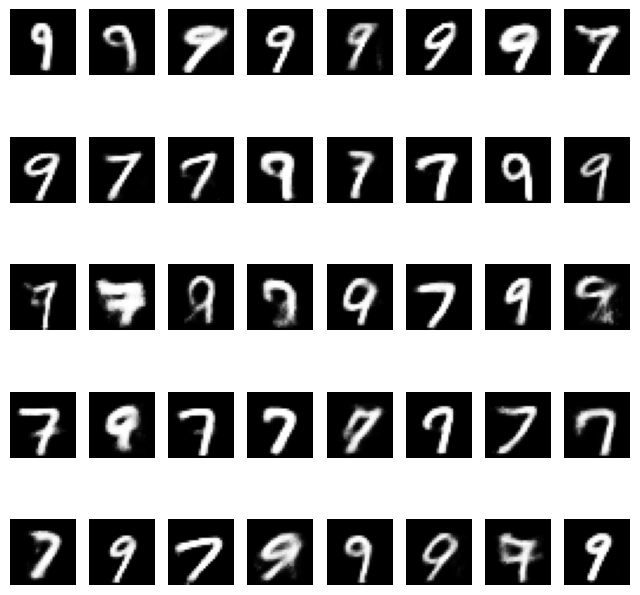

Task 1
MLP Training Epoch 0: Loss 0.213 Acc: 0.910
MLP Training Epoch 1: Loss 0.053 Acc: 0.973
MLP Training Epoch 2: Loss 0.038 Acc: 0.981
MLP Training Epoch 3: Loss 0.030 Acc: 0.986
MLP Training Epoch 4: Loss 0.028 Acc: 0.986
VAE Epoch 1: Loss 15599.717163, Reconstruction Loss 122.473349, Learning Rate: 0.010000
VAE Epoch 2: Loss 15246.207025, Reconstruction Loss 119.697942, Learning Rate: 0.010000
VAE Epoch 3: Loss 15053.967910, Reconstruction Loss 118.188673, Learning Rate: 0.010000
VAE Epoch 4: Loss 15007.944287, Reconstruction Loss 117.827342, Learning Rate: 0.010000
VAE Epoch 5: Loss 14848.523859, Reconstruction Loss 116.575732, Learning Rate: 0.010000
VAE Epoch 6: Loss 14772.102697, Reconstruction Loss 115.975750, Learning Rate: 0.010000
VAE Epoch 7: Loss 14786.673036, Reconstruction Loss 116.090142, Learning Rate: 0.010000
VAE Epoch 8: Loss 14683.808211, Reconstruction Loss 115.282550, Learning Rate: 0.010000
VAE Epoch 9: Loss 14644.086187, Reconstruction Loss 114.970693, Learn

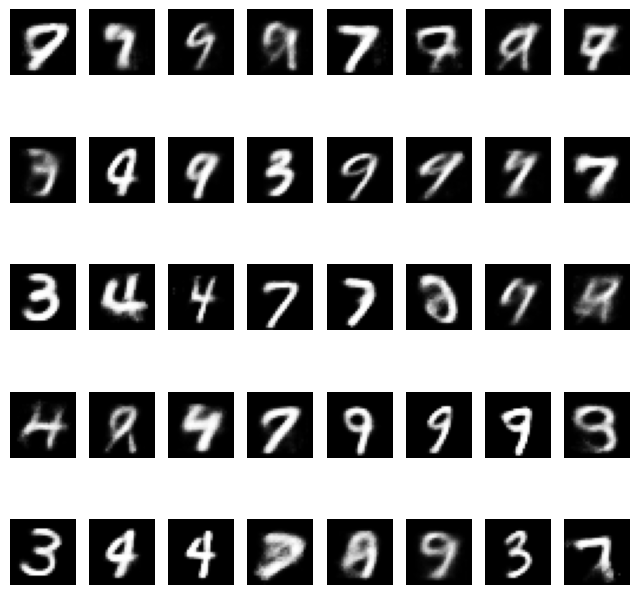

Task 2
MLP Training Epoch 0: Loss 0.219 Acc: 0.886
MLP Training Epoch 1: Loss 0.087 Acc: 0.948
MLP Training Epoch 2: Loss 0.065 Acc: 0.963
MLP Training Epoch 3: Loss 0.058 Acc: 0.966
MLP Training Epoch 4: Loss 0.051 Acc: 0.970
VAE Epoch 1: Loss 18296.758014, Reconstruction Loss 142.967703, Learning Rate: 0.010000
VAE Epoch 2: Loss 18466.482634, Reconstruction Loss 144.293902, Learning Rate: 0.010000
VAE Epoch 3: Loss 18488.755902, Reconstruction Loss 144.467941, Learning Rate: 0.010000
VAE Epoch 4: Loss 18498.051004, Reconstruction Loss 144.540572, Learning Rate: 0.010000
VAE Epoch 5: Loss 18441.197457, Reconstruction Loss 144.096328, Learning Rate: 0.010000
VAE Epoch 6: Loss 18532.255403, Reconstruction Loss 144.807839, Learning Rate: 0.010000
VAE Epoch 7: Loss 18440.672639, Reconstruction Loss 144.092227, Learning Rate: 0.010000
VAE Epoch 8: Loss 18483.816236, Reconstruction Loss 144.429344, Learning Rate: 0.010000
VAE Epoch 9: Loss 18474.591892, Reconstruction Loss 144.357266, Learn

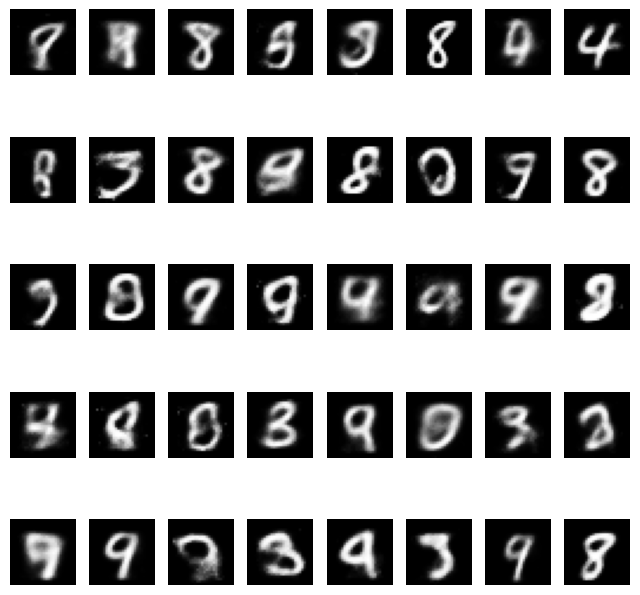

Task 3
MLP Training Epoch 0: Loss 0.238 Acc: 0.866
MLP Training Epoch 1: Loss 0.091 Acc: 0.941
MLP Training Epoch 2: Loss 0.078 Acc: 0.948
MLP Training Epoch 3: Loss 0.072 Acc: 0.954
MLP Training Epoch 4: Loss 0.071 Acc: 0.956
VAE Epoch 1: Loss 19438.874778, Reconstruction Loss 152.010158, Learning Rate: 0.010000
VAE Epoch 2: Loss 18980.859469, Reconstruction Loss 148.428522, Learning Rate: 0.010000
VAE Epoch 3: Loss 18817.285995, Reconstruction Loss 147.149393, Learning Rate: 0.010000
VAE Epoch 4: Loss 18710.883715, Reconstruction Loss 146.317337, Learning Rate: 0.010000
VAE Epoch 5: Loss 18545.237739, Reconstruction Loss 145.022001, Learning Rate: 0.010000
VAE Epoch 6: Loss 18494.940094, Reconstruction Loss 144.628678, Learning Rate: 0.010000
VAE Epoch 7: Loss 18492.130573, Reconstruction Loss 144.606708, Learning Rate: 0.010000
VAE Epoch 8: Loss 18236.425766, Reconstruction Loss 142.607121, Learning Rate: 0.010000
VAE Epoch 9: Loss 18322.932775, Reconstruction Loss 143.283598, Learn

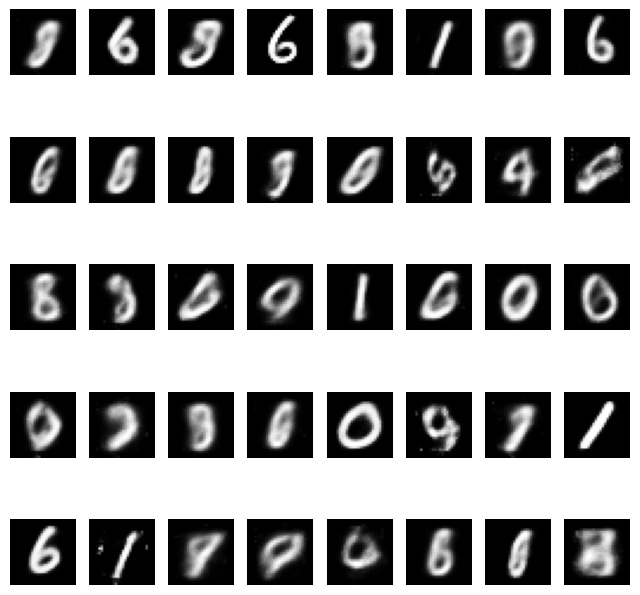

Task 4
MLP Training Epoch 0: Loss 0.375 Acc: 0.787
MLP Training Epoch 1: Loss 0.120 Acc: 0.915
MLP Training Epoch 2: Loss 0.095 Acc: 0.932
MLP Training Epoch 3: Loss 0.084 Acc: 0.938
MLP Training Epoch 4: Loss 0.081 Acc: 0.941


In [ ]:
# Initialize the Agent
agent = Agent(args, train_datasets=train_tasks, val_datasets=val_tasks)

agent.validate()
random_model_acc = [i[0] for i in agent.acc.values()]
agent.reset_acc()

# Train the Agent
agent.train()

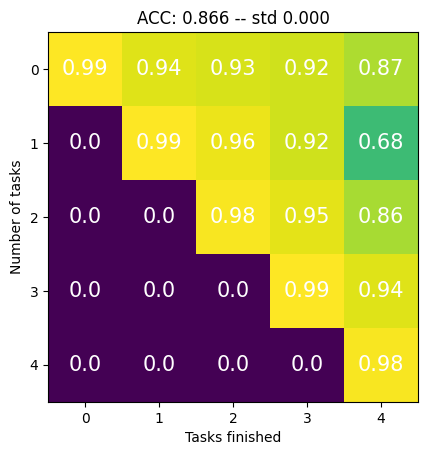

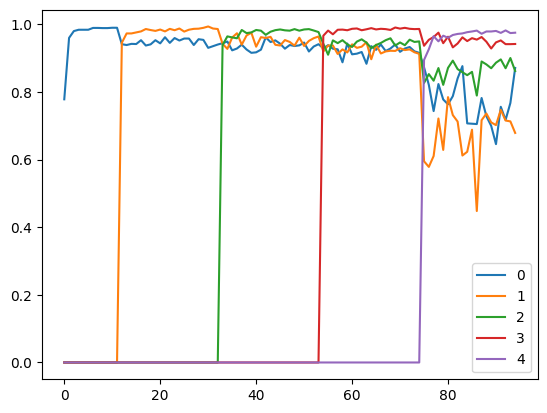

The average accuracy at the end of sequence is: 0.866
BWT:'-0.148'
FWT:'-0.081'


In [ ]:
acc_at_end_arr = dict2array(agent.acc_end)
plot_accuracy_matrix(acc_at_end_arr)

acc_arr = dict2array(agent.acc)
plot_acc_over_time(acc_arr)

print(f"The average accuracy at the end of sequence is: {compute_average_accuracy(acc_at_end_arr):.3f}")
print(f"BWT:'{compute_backward_transfer(acc_at_end_arr):.3f}'")
print(f"FWT:'{compute_forward_transfer(acc_at_end_arr, random_model_acc):.3f}'")

In [ ]:
logger=agent.metric_logger
logger_vae = ([0] + logger.vae_model_sizes)
logger_model = logger.model_sizes
logger.model_sizes = [x + y for x, y in zip(logger_model, logger_vae)]
model_size_efficiency = agent.metric_logger.model_size_efficiency()


In [ ]:
print(f"The average accuracy at the end of sequence is: {compute_average_accuracy(acc_at_end_arr):.3f}")
print(f"BWT:'{compute_backward_transfer(acc_at_end_arr):.3f}'")
print(f"FWT:'{compute_forward_transfer(acc_at_end_arr, random_model_acc):.3f}'")
print(f"Model Size Efficiency: {model_size_efficiency:.3f}")


The average accuracy at the end of sequence is: 0.866
BWT:'-0.148'
FWT:'-0.081'
Model Size Efficiency: 0.447
